In [1]:
# Load the Unet model pre-trained for abnormality segmentation

import torch

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

/home/brian/Documents/Projects/unet_for_brain_mri/.venv/lib/python3.12/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /home/brian/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /home/brian/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [2]:
# Download an example image
import urllib
url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)


In [3]:
import numpy as np
from PIL import Image
from torchvision import transforms

input_image = Image.open(filename)
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

print(torch.round(output[0]))


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


# Trying my own implementation

In [4]:
import pandas as pd
import os

for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/README.md
data/data.csv
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_29.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_4.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_26.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_19_mask.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_8.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_23_mask.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_7_mask.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_27_mask.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_25.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_11_mask.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_35_mask.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_15_mask.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_1.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_11.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_13_mask.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_10.tif
data/TCGA_DU_7301_19911112/TCGA_DU_7301

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = 'data'

images = []
masks = []

for filenames in os.walk(data):
    for filename in filenames[2]:
        if 'mask'in filename:
            masks.append(f'{filenames[0]}/{filename}')
            images.append(f'{filenames[0]}/{filename.replace("_mask", "")}')

In [7]:
df = pd.DataFrame({'image': images, 'mask': masks})

In [8]:
df.head()

,image,mask
0,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...
1,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...
2,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...
3,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...
4,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...,data/TCGA_DU_7301_19911112/TCGA_DU_7301_199111...


In [10]:
print(len(images))
print(len(masks))

3929
3929


In [11]:
import cv2 

def load_and_preprocess(images, masks):
    image_data = []
    mask_data = []
    
    # Load images and masks, convert them to grayscale, and append to lists
    for image_path, mask_path in zip(images, masks):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is not None and mask is not None:
            image_data.append(image)
            mask_data.append(mask)
    
    # Convert lists to NumPy arrays and normalize pixel values to [0, 1]
    image_data = np.array(image_data) / 255.0
    mask_data = np.array(mask_data) / 255.0
    
    # Add an extra channel dimension to handle grayscale images
    image_data = np.expand_dims(image_data, axis=-1)
    mask_data = np.expand_dims(mask_data, axis=-1)
    
    return image_data, mask_data

# Preprocess and return arrays of images and masks
images_array, masks_array = load_and_preprocess(images, masks)

In [12]:


def resize_images(images, masks, target_size=(128, 128)):
    resized_images = []
    resized_masks = []

    # Loop through each image and its corresponding mask
    for image, mask in zip(images, masks):
        # Resize image to target size using INTER_AREA (good for downscaling)
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        # Resize mask to target size using INTER_NEAREST (keeps label boundaries)
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        
        # Append resized image and mask to their respective lists
        resized_images.append(resized_image)
        resized_masks.append(resized_mask)
    
    # Convert the list of resized images and masks into NumPy arrays
    return np.array(resized_images), np.array(resized_masks)

# Set target size to 128x128 and resize images and masks
target_size = (128, 128)
resized_images, resized_masks = resize_images(images_array, masks_array, target_size)


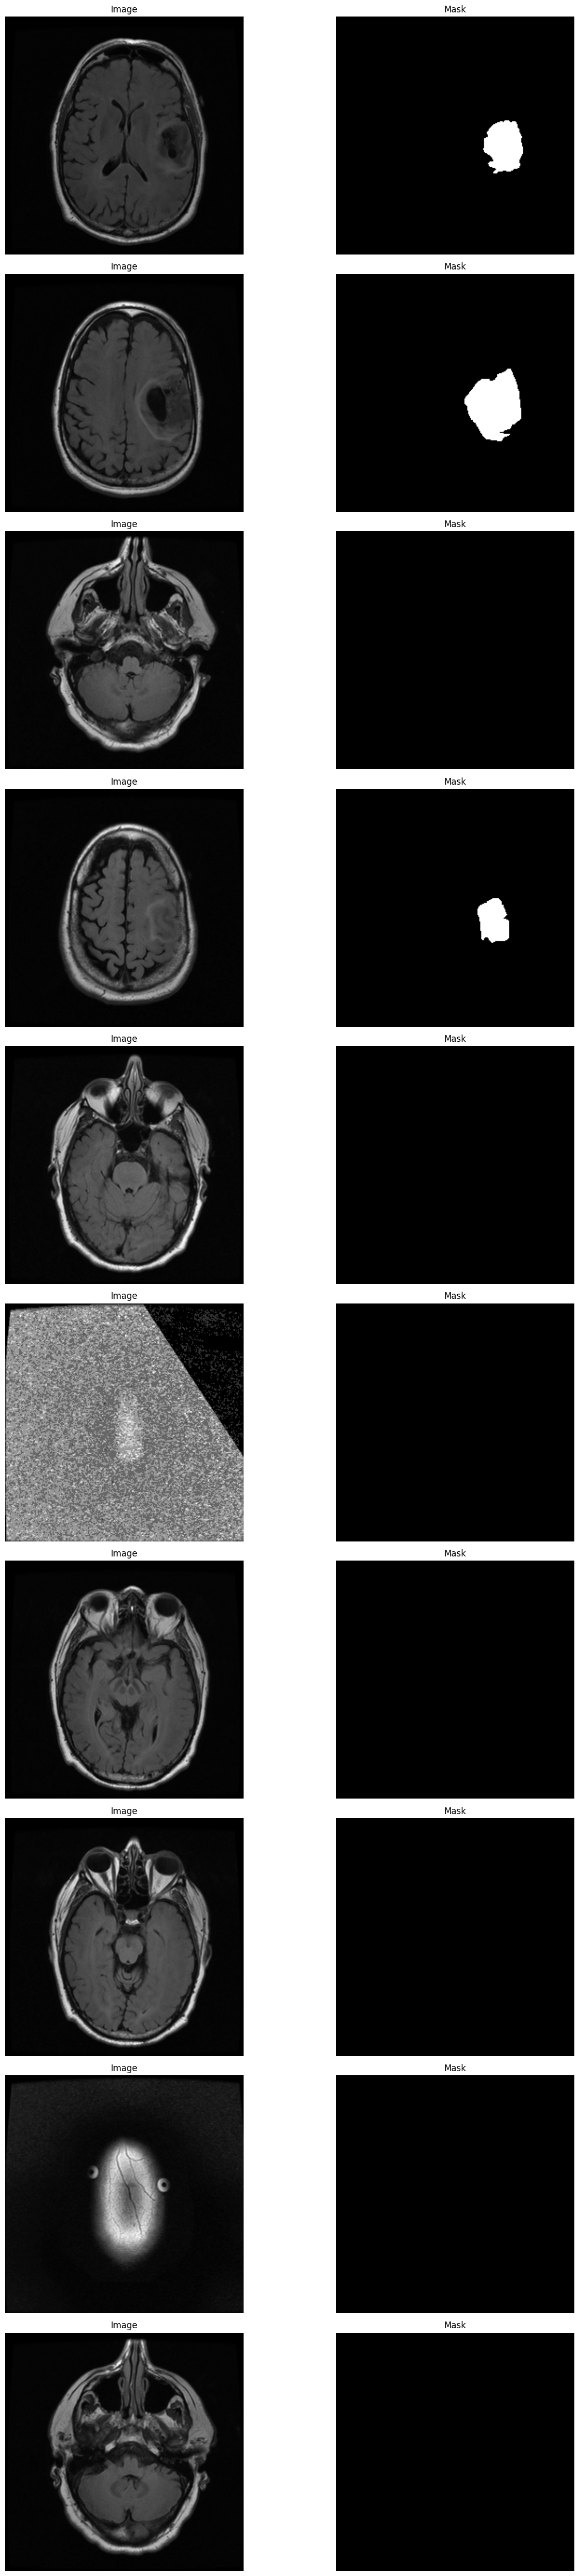

In [13]:
def plot_images(images, masks, num_images=10):
    # Create a figure with a specified size
    plt.figure(figsize=(15, num_images * 5))  # Width of 15 and height based on number of images
    
    for i in range(num_images):
        # Plot image
        plt.subplot(num_images, 2, 2 * i + 1)  # Arrange subplots in a grid with 2 columns
        plt.title('Image')  # Title for the image subplot
        plt.imshow(images[i].squeeze(), cmap='gray')  # Display image in grayscale
        plt.axis('off')  # Hide axis for a cleaner look
        
        # Plot mask
        plt.subplot(num_images, 2, 2 * i + 2)  # Position the mask subplot next to the image
        plt.title('Mask')  # Title for the mask subplot
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Display mask in grayscale
        plt.axis('off')  # Hide axis for a cleaner look
    
    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()  # Display the figure

# Plot a specified number of images and masks
plot_images(images_array, masks_array, num_images=10)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(resized_images, resized_masks, test_size=0.3, random_state=42)

In [15]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [16]:
print(f"training shape: {x_train.shape}")
print(f"test shape: {x_test.shape}")
print(f"val shape: {x_val.shape}")

training shape: (2750, 128, 128)
test shape: (590, 128, 128)
val shape: (589, 128, 128)


In [17]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder (Downsampling)
        self.enc1 = ConvBlock(in_channels, 32)
        self.enc2 = ConvBlock(32, 64)
        self.enc3 = ConvBlock(64, 128)
        self.enc4 = ConvBlock(128, 256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bridge
        self.bridge = ConvBlock(256, 512)
        
        # Decoder (Upsampling)
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(64, 32)
        
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bridge
        bridge = self.bridge(self.pool(enc4))
        
        # Decoder
        dec4 = self.dec4(torch.cat([self.up4(bridge), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.up3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1))
        
        output = self.sigmoid(self.final(dec1))
        return output

# Example usage
if __name__ == "__main__":
    # Create a sample input tensor
    x = torch.randn(1, 3, 256, 256)
    
    # Initialize the UNet model
    model = UNet(in_channels=3, out_channels=1)
    
    # Forward pass
    output = model(x)
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


In [19]:
import torchinfo

torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
UNet                                     --
├─ConvBlock: 1-1                         --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  896
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  9,248
│    │    └─ReLU: 3-4                    --
├─ConvBlock: 1-2                         --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-5                  18,496
│    │    └─ReLU: 3-6                    --
│    │    └─Conv2d: 3-7                  36,928
│    │    └─ReLU: 3-8                    --
├─ConvBlock: 1-3                         --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-9                  73,856
│    │    └─ReLU: 3-10                   --
│    │    └─Conv2d: 3-11                 147,584
│    │    └─ReLU: 3-12                   --
├─ConvBlock: 1-4                         --
│    └─Sequential: 2-4                   --
│    │

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

class BrainMRIDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float().unsqueeze(0)  # Add channel dimension
        mask = torch.from_numpy(self.masks[idx]).float().unsqueeze(0)  # Add channel dimension
        return image, mask
    
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Create datasets and data loaders
train_dataset = BrainMRIDataset(x_train, y_train)
val_dataset = BrainMRIDataset(x_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model, loss function, and optimizer
model = UNet(in_channels=1, out_channels=1)  # Changed in_channels to 1 for grayscale images
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/20, Train Loss: 0.0975, Val Loss: 0.0364
Epoch 2/20, Train Loss: 0.0364, Val Loss: 0.0340
Epoch 3/20, Train Loss: 0.0346, Val Loss: 0.0322
Epoch 4/20, Train Loss: 0.0329, Val Loss: 0.0319
Epoch 5/20, Train Loss: 0.0320, Val Loss: 0.0317
Epoch 6/20, Train Loss: 0.0319, Val Loss: 0.0292
Epoch 7/20, Train Loss: 0.0318, Val Loss: 0.0292
Epoch 8/20, Train Loss: 0.0311, Val Loss: 0.0350
Epoch 9/20, Train Loss: 0.0314, Val Loss: 0.0285
Epoch 10/20, Train Loss: 0.0302, Val Loss: 0.0291
Epoch 11/20, Train Loss: 0.0301, Val Loss: 0.0289
Epoch 12/20, Train Loss: 0.0290, Val Loss: 0.0288
Epoch 13/20, Train Loss: 0.0288, Val Loss: 0.0275
Epoch 14/20, Train Loss: 0.0288, Val Loss: 0.0273
Epoch 15/20, Train Loss: 0.0281, Val Loss: 0.0266
Epoch 16/20, Train Loss: 0.0273, Val Loss: 0.0256
Epoch 17/20, Train Loss: 0.0266, Val Loss: 0.0335
Epoch 18/20, Train Loss: 0.0248, Val Loss: 0.0232
Epoch 19/20, Train Loss: 0.0228, Val Loss: 0.0219
Epoch 20/20, Train Loss: 0.0212, Val Loss: 0.0197


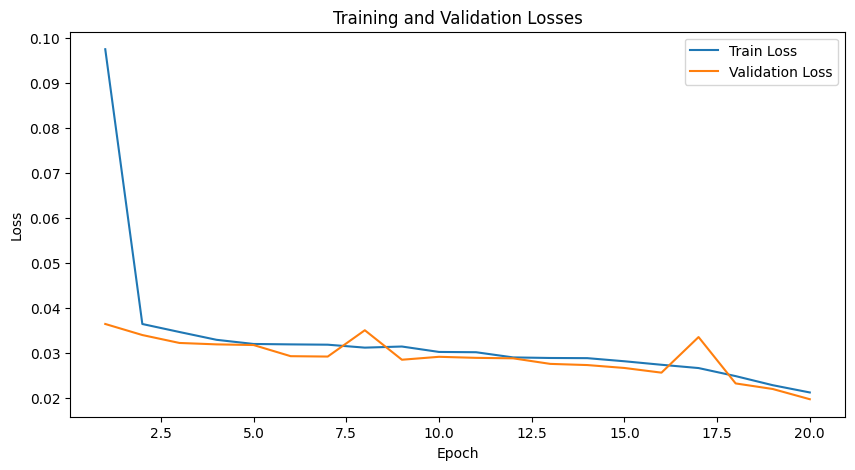

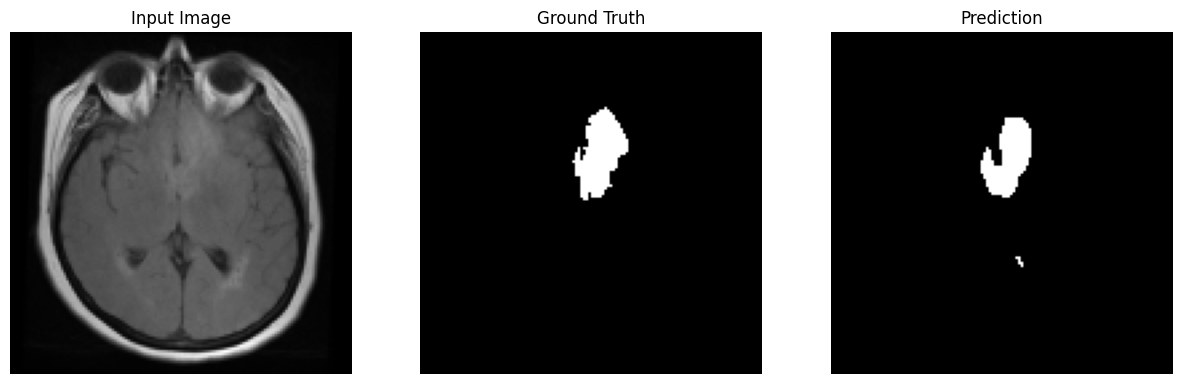

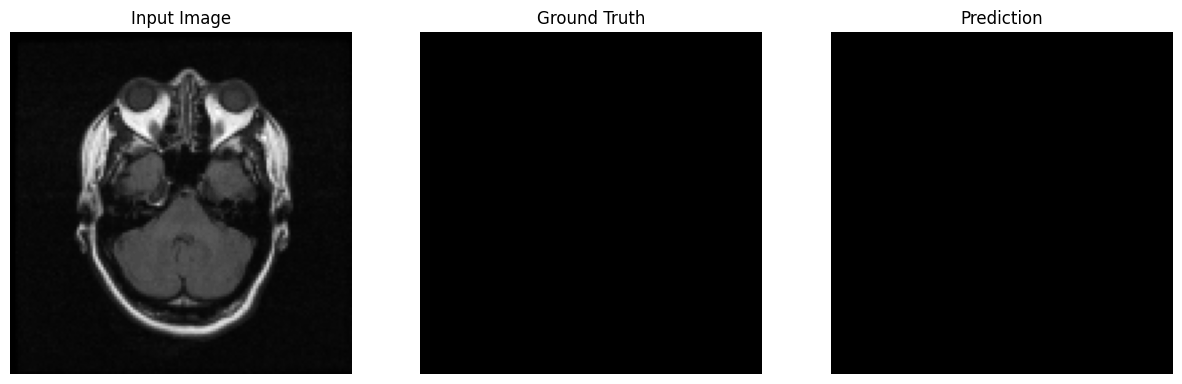

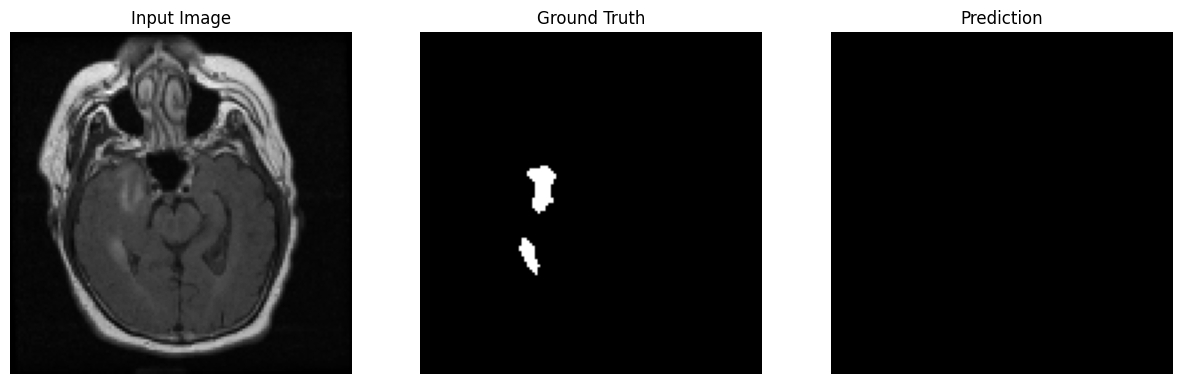

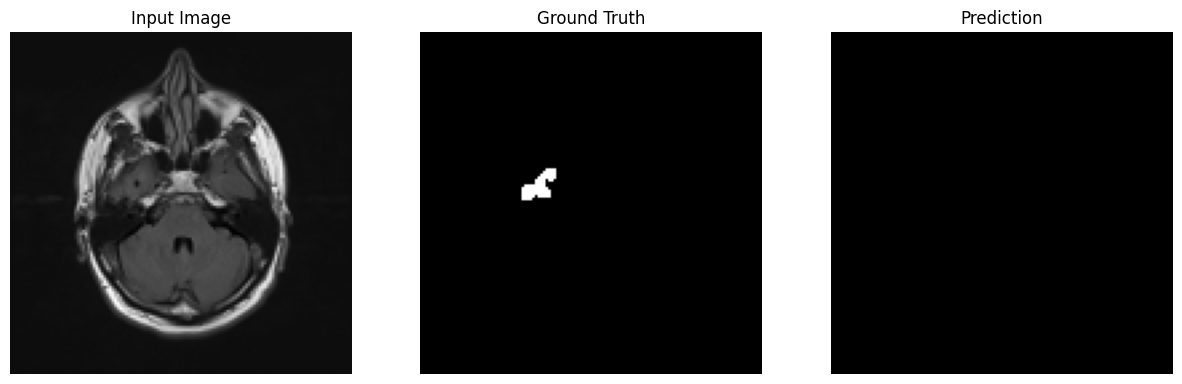

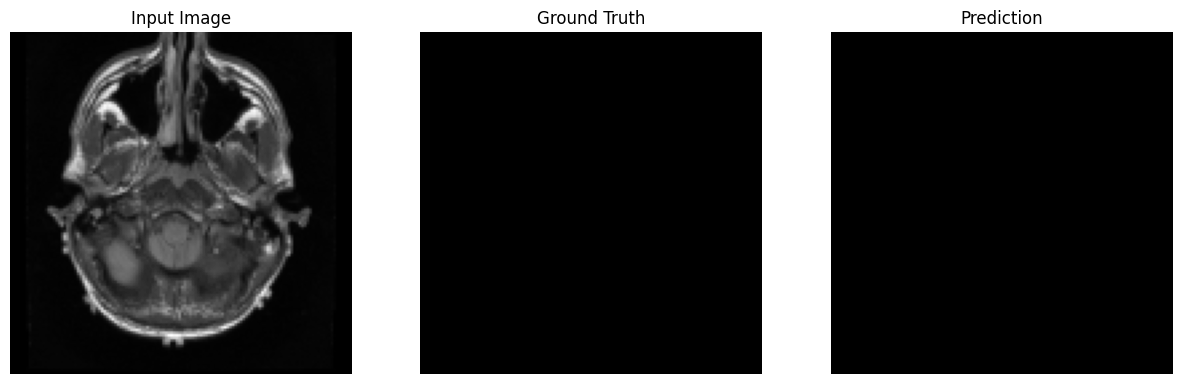

In [22]:

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Function to visualize predictions
def visualize_predictions(model, test_loader, num_images=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            images = images.cpu().numpy()
            masks = masks.cpu().numpy()
            outputs = outputs.cpu().numpy()

            for i in range(num_images):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].squeeze(), cmap='gray')
                plt.title('Input Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i].squeeze(), cmap='gray')
                plt.title('Ground Truth')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(outputs[i].squeeze() > 0.5, cmap='gray')
                plt.title('Prediction')
                plt.axis('off')

                plt.show()

            break  # Only process one batch

# Visualize some predictions
test_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)
visualize_predictions(model, test_loader)



In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'unet_brain_mri_segmentation.pth')